Variational Autoencoder for a Leaf Area Index

## 1. Fetching the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import dask.dataframe as dd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import random

In [ ]:
import zipfile

# Replace the zip_file_path with the path to the zip file in your Google Drive

zip_file_pathLAI = '/content/drive/MyDrive/dataLAITensor.zip'

zip_file_paths = [zip_file_pathLAI]

# Replace the destination_folder with the path of the folder where you want to extract the contents

destination_folderLAI = '/content/dataLAI/'

destination_folders = [destination_folderLAI]

In [ ]:
# Unzip the file

for i in range(len(destination_folders)):
  with zipfile.ZipFile(zip_file_paths[i], 'r') as zip_ref:
      zip_ref.extractall(destination_folders[i])


In [ ]:

sampleCoordinatesLAIIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesLAIIDArrayPositionDf.parquet'
sampleCoordinatesLAIIDArrayPositionDf = dd.read_parquet(sampleCoordinatesLAIIDArrayPositionDf_file).compute()

# Part 2 Custom Dataset

In [ ]:

class CustomRasterDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataFrame, file_path, file_extension,windowSize,re_scale = False,new_min = -1,new_max = 1):
        'Initialization'
        self.re_scale = re_scale
        self.new_min  = new_min
        self.new_max = new_max
        self.dataFrame = dataFrame
        self.file_path = file_path
        self.file_extension = file_extension
        self.windowSize = windowSize
        self.offset = self.windowSize // 2


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataFrame)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID =  self.dataFrame.iloc[index]['ID'] # str(ID).rstrip('.0')

        x = self.dataFrame.iloc[index]['x'] + random.choice([-2, -1, 0, 1, 2])
        y = self.dataFrame.iloc[index]['y'] + random.choice([-2, -1, 0, 1, 2])
        # Load data and get label
        fullArray = torch.load(self.file_path+ID+self.file_extension)
        # Determine the window for the square
        left = x - self.offset
        right = x + (self.offset + 1)
        top = y - self.offset
        bottom = y + (self.offset + 1)
        X = fullArray[left:right,top:bottom].clone().detach()  # Access value in gpu_dictElevation
        # if self.re_scale:
          # X =  re_scale(X,self.new_min,self.new_max)
        return X.unsqueeze(0)

In [ ]:
file_pathLAI = '/content/dataLAI/'


In [ ]:
batch_sizeLAI = 32


In [ ]:
file_extension = '.pt'
num_workers = 2

In [ ]:
windowSizeLAI = 33
datasetLAI = CustomRasterDataset(sampleCoordinatesLAIIDArrayPositionDf, file_pathLAI, file_extension,windowSizeLAI)

In [ ]:
dataLoaderLAI = DataLoader(datasetLAI, batch_size=batch_sizeLAI, num_workers=num_workers, shuffle=True)


In [ ]:
# Assuming you have already created the 'elevation_dataloader' as mentioned in the previous steps

# Get the first batch from the dataloader using the 'next' function
first_batch = next(iter(dataLoaderLAI))
second_batch = next(iter(dataLoaderLAI))
# Print the content of the first batch
print("First Batch:")
print(first_batch.shape)


First Batch:
torch.Size([32, 1, 33, 33])


In [ ]:
loss_weight = len(sampleCoordinatesLAIIDArrayPositionDf)/batch_sizeLAI
loss_weight

29555.59375

# Part 3. Architecture of the LAI VAE

In [ ]:
%%capture
!pip install torchmetrics

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [ ]:
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze')

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 60.7MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the MSE loss function
loss_fn = nn.MSELoss()

In [ ]:
def rescale_tensor(tensor):
    # Find the minimum and maximum values in the tensor
    min_val = tensor.min()
    max_val = tensor.max()

    # Calculate the scaling factors
    scale = 2.0 / (max_val - min_val)
    shift = -1.0 - min_val * scale

    # Rescale the tensor
    rescaled_tensor = tensor * scale + shift

    return rescaled_tensor

In [ ]:

def normalize_tensor01(tensor):
    max_val = torch.max(tensor)
    min_val = torch.min(tensor)

    # Avoid division by zero
    if max_val - min_val != 0:
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
    else:
        normalized_tensor = tensor - min_val

    return normalized_tensor

In [ ]:

class LAIVAELoss(nn.Module):
    def __init__(self):
        super(LAIVAELoss, self).__init__()


    def forward(self, reconstructed_x, x, mu, logvar,lpips):
        # Repeat the last two dimensions three times
        reconstructed_x_repeated =  normalize_tensor01(reconstructed_x).repeat(1, 3, 1, 1)
        x_repeated = normalize_tensor01(x).repeat(1, 3, 1, 1)

        # Compute the Mean Squared Error (MSE) reconstruction loss
        lpips = lpips(reconstructed_x_repeated, x_repeated)
        # Create the L1 loss function
        mse_loss = loss_fn(reconstructed_x,x)
        # Compute the KL divergence term
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Return the sum of the reconstruction loss and KL divergence term
        return kl_divergence +  (lpips*loss_weight)*4 + mse_loss*loss_weight*0.003

In [ ]:

class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2):
        super(ResUp, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))


In [ ]:

# Define the encoder network
class LAIEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(LAIEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 16, 7, 1, 3)

        self.res_down_block1 = ResDown(16,32)
        self.res_down_block2 = ResDown(32, 64)
        self.res_down_block3 = ResDown(64, 128)
        self.res_down_block4 = ResDown(128, 128)

        self.flatten = nn.Flatten()
        self.conv_mu = nn.Linear(1152, latent_dim,)
        self.conv_log_var = nn.Linear(1152, latent_dim)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))

        x = self.res_down_block1(x)  # 8
        x = self.res_down_block2(x)  # 8
        x = self.res_down_block3(x)  # 8
        x = self.res_down_block4(x)  # 8
        x = self.flatten(x)
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class LAIDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(LAIDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.act_fnc1 = nn.ELU()
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 128, 4, 1)
        self.res_up_block1 = ResUp(128, 64)
        self.res_up_block2 = ResUp(64, 32)
        self.res_up_block3 = ResUp(32, 16)
        # self.res_up_block4 = ResUp(16,8)
        # self.res_down_block1 = ResDown(8,4)
        self.conv_out = nn.Conv2d(16, 1, 4, stride=1, padding=2)


    def forward(self, x):
        x = x.view(x.shape[0], self.latent_dim, 1, 1)  # Reshape into a 5x5 tensor
        x = self.act_fnc1(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        # x = self.res_up_block4(x)  # 32
        # x = self.res_down_block1(x)  # 32
        x = self.conv_out(x)

        # x = torch.tanh(self.conv_out3(x))
        return x

# Combine the encoder and decoder to form the VAE
class LAIVAE(nn.Module):
    def __init__(self, latent_dim):
        super(LAIVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = LAIEncoder(latent_dim)
        self.decoder = LAIDecoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x  = self.decode(z)
        return reconstructed_x, mu, logvar



In [ ]:
# Instantiate the VAE with the desired latent_dim
latent_dim = 10
vae = LAIVAE(latent_dim)

dimensions = first_batch.shape
inputs = first_batch#.view(dimensions[0]//3,3,dimensions[2],dimensions[3])
# Pass the input batch through the VAE

In [ ]:


reconstructed_batch, mu, logvar = vae(inputs)

# Check the output shape
print("Reconstructed batch shape:", reconstructed_batch.shape)


Reconstructed batch shape: torch.Size([32, 1, 33, 33])


In [ ]:
def count_parameters(model):
    """
    Count the number of parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The neural network model.

    Returns:
        int: Total number of parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
# model = YourNeuralNetworkClassHere(...)
# print(count_parameters(model))
count_parameters(vae)

826197

# Part 4. Training the LAI VAE

In [ ]:
import torch.optim as optim

In [ ]:
learning_rateLAI = 0.0001

In [ ]:

latent_dimLAI = 20

In [ ]:

# Define the function to train the VAE
def train_vae(vae, dataloader, num_epochs, learning_rate):
    # Set the model to training mode
    vae.train()

    # Define the Mean Squared Error (MSE) loss function
    criterion = LAIVAELoss()
    mse = torch.nn.MSELoss()

    # Define the optimizer (you can experiment with different optimizers)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    total_batches = len(dataloader)
    batches_done = 0
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').to(device)

    for epoch in range(num_epochs):
        total_loss = 0.0
        batches_done =0
        for batch_idx, data in enumerate(dataloader):
            # Get the batch of data and move it to the device (e.g., GPU if available)
            # inputs = data
            dimensions = data.shape

            inputs = data.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            reconstructed_batch, mu, logvar = vae(inputs)
            # Compute the MSE loss
            loss = criterion(reconstructed_batch, inputs,mu, logvar,lpips)
            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Update the total loss for the epoch
            total_loss += loss.item()

            # Update the number of batches processed
            batches_done += 1

            # Print the progress when a tenth of the epoch is completed
            if batches_done % (len(dataloader) // 10) == 0:
                mse_loss = mse(normalize_tensor01(reconstructed_batch),normalize_tensor01(inputs))
                print(f"Epoch [{epoch+1}/{num_epochs}] - Progress: {batches_done}/{len(dataloader)} - Total Loss: {total_loss / (len(dataloader) // 10)},  {mse_loss.item()}")
                total_loss = 0

        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss / ((len(dataloader) - len(dataloader) //10 * 9 ) % 10)}")



In [ ]:
# Example usage:'device = torch.device("cuda" if torch.cuda.is_available() else "cpu")'
# Assuming you have the training data in 'train_dataloader' and a device set, e.g.,
# Instantiate the VAE with the desired latent_dim
vae = LAIVAE(latent_dimLAI).to(device)

# Define the number of epochs and learning rate
num_epochs = 3


In [ ]:
# Train the VAE
train_vae(vae, dataLoaderLAI, num_epochs, learning_rateLAI)

Epoch [1/3] - Progress: 2955/29556 - Total Loss: 25746.178567840525,  0.01123143546283245
Epoch [1/3] - Progress: 5910/29556 - Total Loss: 9741.128989365217,  0.0062631103210151196
Epoch [1/3] - Progress: 8865/29556 - Total Loss: 9258.585511844332,  0.003117504296824336
Epoch [1/3] - Progress: 11820/29556 - Total Loss: 8851.449623585555,  0.0031479152385145426
Epoch [1/3] - Progress: 14775/29556 - Total Loss: 8719.010087675815,  0.0030790483579039574
Epoch [1/3] - Progress: 17730/29556 - Total Loss: 8501.111571687288,  0.002675221534445882
Epoch [1/3] - Progress: 20685/29556 - Total Loss: 8526.321819149218,  0.002667220076546073
Epoch [1/3] - Progress: 23640/29556 - Total Loss: 8293.085143691836,  0.00476072309538722
Epoch [1/3] - Progress: 26595/29556 - Total Loss: 8322.155870115535,  0.00319802388548851
Epoch [1/3] - Progress: 29550/29556 - Total Loss: 8226.429824813611,  0.004138113930821419
Epoch [1/3] - Loss: 49216.7626953125
Epoch [2/3] - Progress: 2955/29556 - Total Loss: 8130.6

In [ ]:
# Train the VAE
train_vae(vae, dataLoaderLAI, 2, learning_rateLAI)

Epoch [1/2] - Progress: 2955/29556 - Total Loss: 7445.276270192206,  0.0027605979703366756
Epoch [1/2] - Progress: 5910/29556 - Total Loss: 7434.593223052823,  0.002546663861721754
Epoch [1/2] - Progress: 8865/29556 - Total Loss: 7522.378586677771,  0.0019120346987619996
Epoch [1/2] - Progress: 11820/29556 - Total Loss: 7476.241297522737,  0.002596432575955987
Epoch [1/2] - Progress: 14775/29556 - Total Loss: 7440.087709688293,  0.0024737801868468523
Epoch [1/2] - Progress: 17730/29556 - Total Loss: 7466.936958677031,  0.0020981663838028908
Epoch [1/2] - Progress: 20685/29556 - Total Loss: 7362.2124747184325,  0.002497249050065875
Epoch [1/2] - Progress: 23640/29556 - Total Loss: 7359.96360247462,  0.0027218908071517944
Epoch [1/2] - Progress: 26595/29556 - Total Loss: 7436.552195530616,  0.002602073596790433
Epoch [1/2] - Progress: 29550/29556 - Total Loss: 7413.931740925074,  0.002805002499371767
Epoch [1/2] - Loss: 41785.72216796875
Epoch [2/2] - Progress: 2955/29556 - Total Loss: 7

In [ ]:
torch.save(vae, 'vaeLAI5_ME_Epoch.pt')

In [ ]:
!mv vaeLAI5_ME_Epoch.pt "/content/drive/MyDrive/Colab Notebooks/"

# Part 5. Plotting the results of the LAI VAE

In [ ]:
def get_random_batch(dataloader):
    # Get the total number of batches in the DataLoader
    num_batches = len(dataloader)

    # Generate a random index to select a batch
    random_batch_index = torch.randint(0, 100, (1,))

    # Iterate through the DataLoader to find the batch at the random index
    for i, batch in enumerate(dataloader):
        if i == random_batch_index:
            return batch


In [ ]:
randomBatch = get_random_batch(dataLoaderLAI)

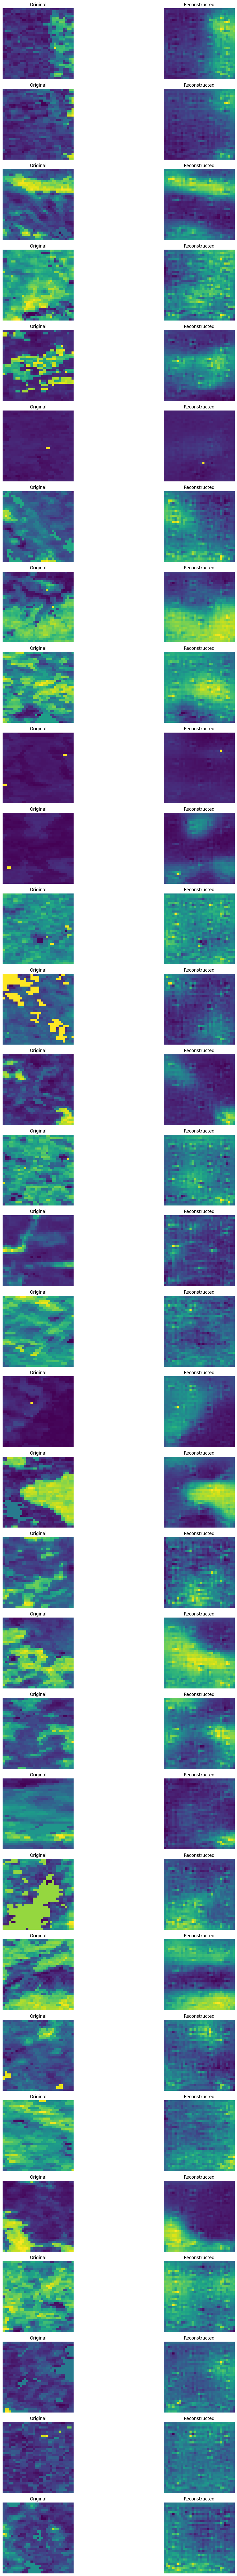

In [ ]:
import torch
import matplotlib.pyplot as plt

def compare_vae_reconstructionLAI(vae, data_batch, device):
    # Set the VAE to evaluation mode
    vae.eval()

    # Get the batch size and number of channels
    batch_size, num_channels, height, width = data_batch.size()

    # Get the reconstructed images from the VAE
    with torch.no_grad():

        inputs = data_batch

        reconstructed_batch, _, _ = vae(inputs.to(device))

    # Convert the tensors to numpy arrays and transpose the dimensions
    original_images = data_batch.cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed_images = reconstructed_batch.cpu().numpy().transpose(0, 2, 3, 1)
    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(100, 100))

    for i in range(batch_size):
        plt.subplot(batch_size, 16, i*16 + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title('Original')

        plt.subplot(batch_size, 16, i*16 + 2)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        plt.title('Reconstructed')


    plt.tight_layout()
    plt.show()

# Usage
# Assuming 'vae' is your trained Variational Autoencoder model
# and 'data_batch' is your batch of input images
# 'device' should be the device on which your model is (e.g., 'cuda' or 'cpu')
compare_vae_reconstructionLAI(vae, randomBatch, device)


In [ ]:
import torch.nn.functional as F

def normalize_tensor01(tensor):
    max_val = torch.max(tensor)
    min_val = torch.min(tensor)

    # Avoid division by zero
    if max_val - min_val != 0:
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
    else:
        normalized_tensor = tensor - min_val

    return normalized_tensor

def normalized_mse(tensor1, tensor2):
    # Normalize the tensors
    norm_tensor1 = normalize_tensor01(tensor1)
    norm_tensor2 = normalize_tensor01(tensor2)

    # Compute MSE
    mse_loss_normalized = F.mse_loss(norm_tensor1, norm_tensor2)
    mse_loss =  F.mse_loss(tensor1, tensor2)

    return mse_loss_normalized, mse_loss

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



# Compute average normalized MSE for the first 100 batches
def compute_average_mse(dataloader):
    mse_values = []
    count = 0

    for data in dataloader:
        if count >= 10000:
            break

        # Generate random "predictions" just for the sake of the example
        # In a real scenario, these would be the model's output
        reconstructed_batch, _, _ = vae(data.to(device))

        mse,mse2 = normalized_mse(data.cpu(), reconstructed_batch.cpu())
        mse_values.append(mse.item())

        count += 1

    average_mse = sum(mse_values) / len(mse_values)
    print("Average Normalized MSE:", average_mse)

# Example usage
# Replace `your_dataloader` with the DataLoader you have
compute_average_mse(dataLoaderLAI)


Average Normalized MSE: 0.009602884255250682
